# End-to-end machine learning project
This notebook is a simplified version of the intro ML project presented by Aurelion Geron in pages 37-85.  
For the complete original notebook, see the `aurelion` folder.

#### start with importing our Python libraries

In [1]:
# common imports
from pathlib import Path
import numpy as np
import pandas as pd

# sci-kit learn is our one-stop shop for machine learning!
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,  mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Exploratory Data Analysis

In [2]:
# read in the dataset
filepath = Path.joinpath(Path.cwd().parent, 'data', 'housing.csv')
housing = pd.read_csv(filepath)
housing.sample(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


Decide what is our variable of interest (this is the item we want to predict, aka the Dependent Variable, labels, or target)

In [3]:
housing['median_house_value'].describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

#### What is the story of one row?
"In this chapter we chose the California Housing Prices dataset from the StatLib repository2 (see Figure 2-1). This dataset was based on data from the 1990 California census. It is not exactly recent (you could still afford a nice house in the Bay Area at the time), but it has many qualities for learning, so we will pretend it is recent data. We also added a categorical attribute and removed a few features for teaching purposes." 

"Each row represents one district. There are 10 attributes (you can see the first 6 in the screenshot): longitude, latitude, housing_median_age, total_rooms, total_bed rooms, population, households, median_income, median_house_value, and ocean_proximity."  
-- Geron, pg. 38

## Feature Engineering

In [4]:
# Create income categories
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [5]:
# Create some additional variables
housing["rooms_per_hhold"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["pop_per_household"]=housing["population"]/housing["households"]

In [6]:
# Create dummy variables for ocean proximity
housing=pd.get_dummies(housing, columns = ['ocean_proximity'], prefix='', prefix_sep='')

In [7]:
# what are the variables?
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'income_cat', 'rooms_per_hhold',
       'bedrooms_per_room', 'pop_per_household', '<1H OCEAN', 'INLAND',
       'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype='object')

## Prepare the data for Machine Learning algorithms

#### Get rid of missing data
Geron actually shows multiple options here (such as imputing the median) but we're just going to drop all rows with missing data.

In [8]:
# sklearn cannot handle missing data. 
print(housing.isnull().sum())
housing.dropna(axis=1, inplace=True)

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
income_cat              0
rooms_per_hhold         0
bedrooms_per_room     207
pop_per_household       0
<1H OCEAN               0
INLAND                  0
ISLAND                  0
NEAR BAY                0
NEAR OCEAN              0
dtype: int64


#### Feature scaling
"One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the hous‐ ing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Note that scaling the target values is generally not required.
There are two common ways to get all attributes to have the same scale: min-max scaling (i.e., normalization) and standardization."  -- Geron, pg. 72

"Standardization is quite different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algo‐ rithms (e.g., neural networks often expect an input value ranging from 0 to 1). However, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–15 down to 0–0.15, whereas standardization would not be much affected. Scikit-Learn provides a transformer called StandardScaler for standardization."  -- Geron, pg. 73

In [9]:
# What are the numeric variables in my dataset?
housing.describe().columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'population', 'households', 'median_income', 'median_house_value',
       'rooms_per_hhold', 'pop_per_household', '<1H OCEAN', 'INLAND', 'ISLAND',
       'NEAR BAY', 'NEAR OCEAN'],
      dtype='object')

Note: Geron includes `median_house_value` in his scaling, but I do not. It's not actually necessary to scale your dependent variable (i.e., your target) and leaving it in the original metric makes the results a lot easier to interpret.

In [10]:
# For the purpose of scaling, make a list of only the numeric columns
numeric_cols=housing.columns.drop(['median_house_value'])
print(numeric_cols)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'population', 'households', 'median_income', 'income_cat',
       'rooms_per_hhold', 'pop_per_household', '<1H OCEAN', 'INLAND', 'ISLAND',
       'NEAR BAY', 'NEAR OCEAN'],
      dtype='object')


Note: The following code only works because we dropped missing data earlier. This is pretty common in `sklearn` -- either drop or impute missing values at the start of your analysis!

In [11]:
# "Instantiate" the scaler (create an instance of the sklearn class)
std_scaler = StandardScaler()
std_scaler

StandardScaler()

In [12]:
# 'Fit' the scaler to our data
scaled_results = std_scaler.fit_transform(housing[numeric_cols])
scaled_results[:2]

array([[-1.32783522,  1.05254828,  0.98214266, -0.8048191 , -0.9744286 ,
        -0.97703285,  2.34476576,  1.89012782,  0.62855945, -0.04959654,
        -0.89115574, -0.68188905, -0.01556621,  2.83074203, -0.38446649],
       [-1.32284391,  1.04318455, -0.60701891,  2.0458901 ,  0.86143887,
         1.66996103,  2.33223796,  1.89012782,  0.32704136, -0.09251223,
        -0.89115574, -0.68188905, -0.01556621,  2.83074203, -0.38446649]])

In [13]:
# convert those results into a dataframe
scaled_df = pd.DataFrame(scaled_results, columns=numeric_cols)
scaled_df.head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,income_cat,rooms_per_hhold,pop_per_household,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-1.327835,1.052548,0.982143,-0.804819,-0.974429,-0.977033,2.344766,1.890128,0.628559,-0.049597,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
1,-1.322844,1.043185,-0.607019,2.045890,0.861439,1.669961,2.332238,1.890128,0.327041,-0.092512,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
2,-1.332827,1.038503,1.856182,-0.535746,-0.820777,-0.843637,1.782699,1.890128,1.155620,-0.025843,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
3,-1.337818,1.038503,1.856182,-0.624215,-0.766028,-0.733781,0.932968,0.941894,0.156966,-0.050329,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
4,-1.337818,1.038503,1.856182,-0.462404,-0.759847,-0.629157,-0.012881,-0.006340,0.344711,-0.085616,-0.891156,-0.681889,-0.015566,2.830742,-0.384466


In [14]:
# Drop the original numeric columns
housing = housing.drop(numeric_cols, axis=1)

In [15]:
# Merge that sub-dataframe back into the updated original housing dataframe
housing = pd.concat([housing, scaled_df], axis=1)

In [16]:
# Display a sample of those results 
housing.sample(5)

,median_house_value,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,income_cat,rooms_per_hhold,pop_per_household,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
20512,69600.0,-0.988426,1.384961,0.584852,-1.008801,-1.007102,-1.071195,-1.390412,-1.902808,-0.240760,0.009244,-0.891156,1.466514,-0.015566,-0.353264,-0.384466
15568,335600.0,1.262653,-1.190065,-1.004309,0.935677,0.420795,0.173834,1.217370,1.890128,1.145562,0.027900,1.122138,-0.681889,-0.015566,-0.353264,-0.384466
4047,500001.0,0.528931,-0.698469,-0.050812,1.884996,0.887930,0.984672,4.746470,1.890128,0.919197,-0.028456,1.122138,-0.681889,-0.015566,-0.353264,-0.384466
18127,360600.0,-1.223018,0.799728,0.108104,-0.733311,-0.846386,-0.898565,1.356649,1.890128,0.489883,-0.007420,1.122138,-0.681889,-0.015566,-0.353264,-0.384466
3548,276600.0,0.479018,-0.646969,-1.004309,2.594121,2.187785,2.488646,0.863486,0.941894,0.116303,-0.036664,1.122138,-0.681889,-0.015566,-0.353264,-0.384466


#### Train-test split

"The only way to know how well a model will generalize to new cases is to actually try it out on new cases. One way to do that is to put your model in production and moni‐ tor how well it performs. This works well, but if your model is horribly bad, your users will complain—not the best idea.
A better option is to split your data into two sets: the training set and the test set. As these names imply, you train your model using the training set, and you test it using the test set. The error rate on new cases is called the generalization error (or out-of- sample error), and by evaluating your model on the test set, you get an estimate of this error. This value tells you how well your model will perform on instances it has never seen before."  -- Geron, pg. 31

In [17]:
# First, split your data into features (X) and labels (y).
y = housing["median_house_value"].copy()
X = housing.drop(["median_house_value", "<1H OCEAN"], axis=1)
# Compare their shapes.
print(y.shape)
print(X.shape)

(20640,)
(20640, 14)


In [18]:
# Now, split both X and y data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=0.2, 
                                       random_state=42)

In [19]:
# Compare the shapes to confirm this did what you wanted.
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16512, 14)
(16512,)
(4128, 14)
(4128,)


## Select and train a model

In [20]:
# Create a local instance of the sklearn class, and show its options
lin_reg = LinearRegression()
lin_reg

LinearRegression()

In [21]:
# Fit your instance to the training dataset
lin_reg.fit(X_train, y_train)

LinearRegression()

In [22]:
# display the intercept
lin_reg.intercept_

206754.98086264374

In [23]:
# display coefficients
lin_reg.coef_

array([-53268.34535202, -55032.35983727,  14081.81699242, -10368.86127772,
       -47000.69645518,  62124.21352743,  62035.1974818 ,   9993.28718   ,
         7292.38867003,   1081.51207051, -18657.47498636,   2293.29683112,
        -1267.70465266,   1316.39289871])

In [24]:
# Display intercept and coefficients as a dataframe
cols=list(X_train.columns)
coefs=list(lin_reg.coef_)
coefs=[int(x) for x in coefs]
# add the intercept
cols.insert(0, "intercept")
coefs.insert(0, int(lin_reg.intercept_))
# combine into a dataframe
regression_components = pd.DataFrame(coefs, cols, columns=['coefficients'])
regression_components 

,coefficients
intercept,206754
longitude,-53268
latitude,-55032
housing_median_age,14081
total_rooms,-10368
population,-47000
households,62124
median_income,62035
income_cat,9993
rooms_per_hhold,7292


In [25]:
# what is the equation for this model?

xcoefs = [(coefs[i], cols[i]) for i in range(0, len(cols))]

output = f"""y =  {round(lin_reg.intercept_,2)} + 
                {round(xcoefs[0][0],2)}*{xcoefs[0][1]} + 
                {round(xcoefs[1][0],2)}*{xcoefs[1][1]} + 
                {round(xcoefs[2][0],2)}*{xcoefs[2][1]} + 
                {round(xcoefs[3][0],2)}*{xcoefs[3][1]} + 
                {round(xcoefs[4][0],2)}*{xcoefs[4][1]} + 
                {round(xcoefs[5][0],2)}*{xcoefs[5][1]} + 
                {round(xcoefs[6][0],2)}*{xcoefs[6][1]} + 
                {round(xcoefs[7][0],2)}*{xcoefs[7][1]} + 
                {round(xcoefs[8][0],2)}*{xcoefs[8][1]} +
                {round(xcoefs[9][0],2)}*{xcoefs[9][1]} + 
                {round(xcoefs[10][0],2)}*{xcoefs[10][1]} + 
                {round(xcoefs[11][0],2)}*{xcoefs[11][1]} + 
                {round(xcoefs[12][0],2)}*{xcoefs[12][1]} + 
                {round(xcoefs[13][0],2)}*{xcoefs[13][1]} 
                """
print("Regression Equation: ", "\n", output)  

Regression Equation:  
 y =  206754.98 + 
                206754*intercept + 
                -53268*longitude + 
                -55032*latitude + 
                14081*housing_median_age + 
                -10368*total_rooms + 
                -47000*population + 
                62124*households + 
                62035*median_income + 
                9993*income_cat +
                7292*rooms_per_hhold + 
                1081*pop_per_household + 
                -18657*INLAND + 
                2293*ISLAND + 
                -1267*NEAR BAY 
                


## Make predictions on your testing dataset

In [26]:
# Make predictions on the testing dataset
y_preds = lin_reg.predict(X_test)

In [27]:
# Examine your predictions
y_preds

array([ 48646.36079914, 142586.97421779, 319088.42978437, ...,
       434697.81249877, 122516.33885779, 181666.30421855])

In [28]:
# How do the first five predictions compare to the first five actual values?
true_5=list(round(y_test[:5], 1))
pred_5=[round(x,1) for x in list(y_preds[:5])]
print('true values:', true_5)
print('predicted values:', pred_5)

true values: [47700.0, 45800.0, 500001.0, 218600.0, 278000.0]
predicted values: [48646.4, 142587.0, 319088.4, 276866.0, 266687.2]


In [29]:
# How do we intepret those results?
first_5=['district0', 'district1', 'district2', 'district3', 'distict4']
pd.DataFrame(list(zip(first_5, true_5, pred_5)), columns=['district', 'true', 'predicted'])

,district,true,predicted
0,district0,47700.0,48646.4
1,district1,45800.0,142587.0
2,district2,500001.0,319088.4
3,district3,218600.0,276866.0
4,distict4,278000.0,266687.2


## Examine the feature importances

In [30]:
# 'Attributes' is another name for our list of features (aka predictors, independent variables)
attributes=X_test.columns
print(attributes)
# 'Feature importances' is another name for our coefficients (ie., the impace of each feature on the outcome or DV)
feature_importances=lin_reg.coef_
print(feature_importances)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'population', 'households', 'median_income', 'income_cat',
       'rooms_per_hhold', 'pop_per_household', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN'],
      dtype='object')
[-53268.34535202 -55032.35983727  14081.81699242 -10368.86127772
 -47000.69645518  62124.21352743  62035.1974818    9993.28718
   7292.38867003   1081.51207051 -18657.47498636   2293.29683112
  -1267.70465266   1316.39289871]


In [31]:
# obviously, these 2 things will have the same length
print(len(feature_importances))
print(len(attributes))

14
14


In [32]:
[int(x) for x in list(feature_importances)]

[-53268,
 -55032,
 14081,
 -10368,
 -47000,
 62124,
 62035,
 9993,
 7292,
 1081,
 -18657,
 2293,
 -1267,
 1316]

In [33]:
# let's take a look at the results
feature_imp = pd.DataFrame(list(zip(attributes, feature_importances)), columns=['features', 'coeffs'])
feature_imp=feature_imp.set_index('features')
feature_imp=feature_imp.sort_values('coeffs')
feature_imp

,coeffs
features,
latitude,-55032.359837
longitude,-53268.345352
population,-47000.696455
INLAND,-18657.474986
total_rooms,-10368.861278
NEAR BAY,-1267.704653
pop_per_household,1081.512071
NEAR OCEAN,1316.392899
ISLAND,2293.296831


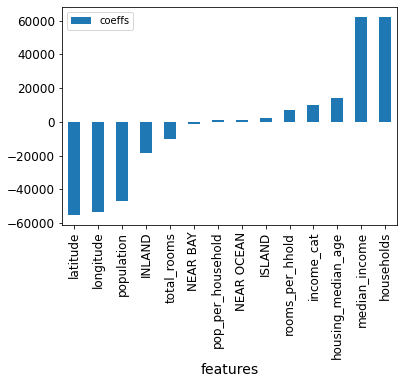

In [34]:
# plot that as a bar chart
feature_imp.plot(kind='bar');

## Evaluate your model

In [35]:
# root mean squared error represents the average error (in $) of our model
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_preds))
round(rmse,2)

69479.14

In [36]:
# how does this compare to the mean of our training set?
avg_val = round(y_train.mean(),2)
avg_val

207194.69

In [37]:
# If we used that as our predictor, then the average error of our model would be:
comparison_array=np.full((len(y_test), ), avg_val)
coin_flip=np.sqrt(metrics.mean_squared_error(y_test, comparison_array))
print(round(coin_flip))

114486


In [38]:
# R-squared is another important metric
r2=metrics.r2_score(y_test, y_preds)
round(r2, 2)

0.63

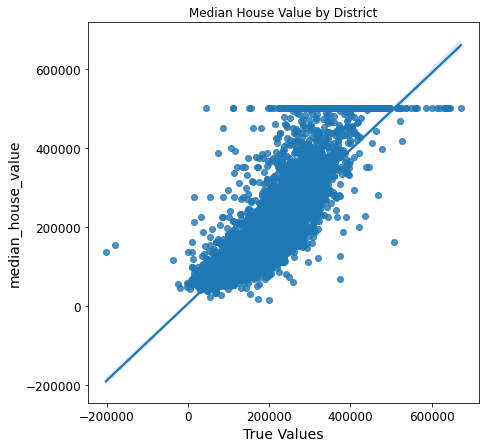

In [39]:
# Visualize our true vs. predicted values
import seaborn as sns
plt.figure(figsize=(7,7))
plt.title('Median House Value by District')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
fig=sns.regplot(x=y_preds, y=y_test)
plt.show(fig)